In this experiment, we are going to visualize the uncertainty of a deep neural network by
using dropout as a mean of Bayesian Approximation [[1]](https://arxiv.org/abs/1506.02142).

We are going to use the [monkey species dataset from Kaggle](https://www.kaggle.com/slothkong/10-monkey-species).
If you want to run this notebook, clone it in your Colab, get your Kaggle API key,
upload it on your Colab, download the Kaggle monkey dataset and start cracking.

# Download Dataset from Kaggle

In [0]:
! pip install -q kaggle
from google.colab import files

This is where you upload your Kaggle API JSON file.
Steps to do that: Go to your Kaggle account and look for API token generation section.
Expire your previous tokens (if you have any of them) and then, create a new token. You can
just create a new token without expiring your previous tokens if you wish too.
This will download a `Kaggle.json` file. Upload this file in the following step.

In [0]:
# Run this cell and press Browse to upload Kaggle.json file
files.upload()

### Download local copy of monkey dataset

In [0]:
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d slothkong/10-monkey-species
! mkdir monkey_dataset
! unzip 10-monkey-species.zip -d monkey_dataset

## Clone git repo and get supporting scripts (Only for Colab)

In [0]:
## If you are running this notebook in Colab, uncomment the following lines
!git clone https://github.com/ArkAung/dropout_bayesian_nn.git
!cp dropout_bayesian_nn/network.py network.py
!cp dropout_bayesian_nn/dataset.py dataset.py
!cp dropout_bayesian_nn/plotting.py plotting.py
!cp dropout_bayesian_nn/bayesian_approx.py bayesian_approx.py

# Preparation

In [0]:
# Disable eager execution for K.function() with learning_phase to work properly
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [0]:
from network import Network
from plotting import plot_grid, visualize_probdist
from dataset import Dataset, DatasetType
from bayesian_approx import run_bayesian_approx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
IMAGE_SHAPE = (224, 224, 3)
BATCH_SIZE = 32

train_dir = 'monkey_dataset/training/training'
test_dir = 'monkey_dataset/validation/validation'

# The CSV file contains spaces for data fields and column names which we need to remove.
monkey_labels = pd.read_csv("monkey_dataset/monkey_labels.txt")
monkey_labels.columns = [c.strip() for c in monkey_labels.columns]
monkey_labels['Label'] = monkey_labels['Label'].str.strip()
monkey_labels['Common Name'] = monkey_labels['Common Name'].str.strip()

### Plot Training and Testing Data Count Distribution

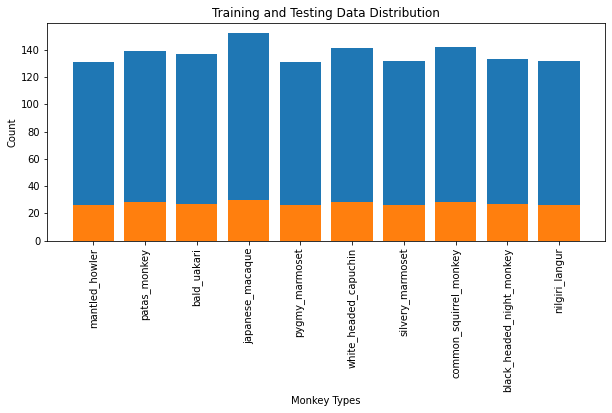

In [8]:
plt.figure(figsize=(10,4))

plt.bar(range(len(monkey_labels['Train Images'])), monkey_labels['Train Images'])
plt.bar(range(len(monkey_labels['Validation Images'])), monkey_labels['Validation Images'])
plt.xticks(range(len(monkey_labels['Common Name'])), monkey_labels['Common Name'], rotation=90)
plt.xlabel('Monkey Types')
plt.ylabel('Count')
plt.title('Training and Testing Data Distribution')
plt.show()

# Visualize Monkeys in the Dataset

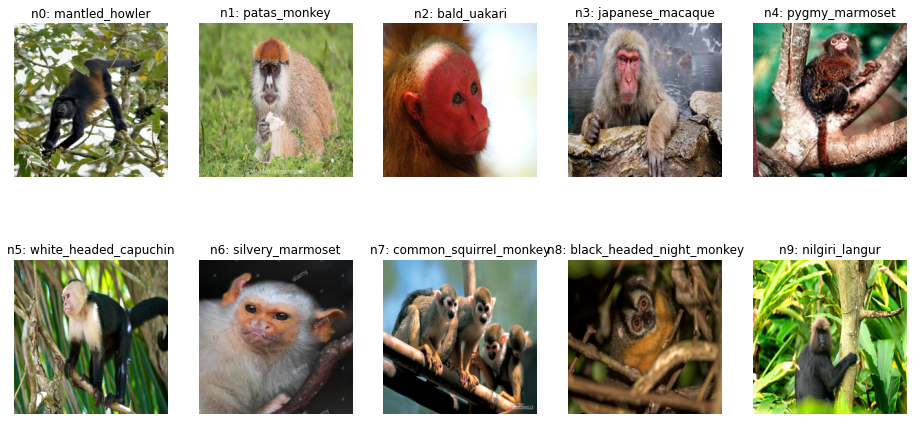

In [9]:
# Title in the form of [Class Folder Name]: [Common Name]
plot_grid(rows=2, cols=5, figsize=(16,8),
          image_root_path=train_dir, labels=monkey_labels, data_shape=IMAGE_SHAPE[:2])

We want to train **some classes** of monkeys and later observe how our model performs for classes of monkeys which the model was never shown before (testing out of distribution uncertainty). But this is not as extreme as testing out on completely different looking data samples (like objects). We will also see how the model does on completely different looking data samples.

We are going to train our network to recognize the first five class of monkeys (the first row) and later test our model on the classes of monkeys which are on the second row.

In [0]:
# Selecting classes of monkey to train
class_filter = ['n0', 'n1', 'n2', 'n3', 'n4']
label_mapping = monkey_labels['Common Name'][:5].to_dict() # Get class folder name -> common name mapping by taking the first five rows from dataframe

In [11]:
label_mapping

{0: 'mantled_howler',
 1: 'patas_monkey',
 2: 'bald_uakari',
 3: 'japanese_macaque',
 4: 'pygmy_marmoset'}

# Training

In [12]:
train_dataset = Dataset(path=train_dir, target_size=IMAGE_SHAPE[:2], dataset_type=DatasetType.TRAIN,
                        batch_size=BATCH_SIZE,
                        class_filter=class_filter,
                        label_mapping=label_mapping)

val_dataset = Dataset(path=train_dir, target_size=IMAGE_SHAPE[:2], dataset_type=DatasetType.VAL,
                      batch_size=BATCH_SIZE,
                      data_generator=train_dataset.data_generator,
                      class_filter=class_filter,
                      label_mapping=label_mapping)

test_dataset = Dataset(path=test_dir, target_size=IMAGE_SHAPE[:2], dataset_type=DatasetType.TEST,
                       batch_size=BATCH_SIZE,
                       class_filter=class_filter,
                       label_mapping=label_mapping)

Found 443 images belonging to 5 classes.
Found 110 images belonging to 5 classes.
Found 137 images belonging to 5 classes.


In [0]:
net = Network(input_shape=IMAGE_SHAPE, dropout_rate=0.2, num_classes=len(class_filter))

In [29]:
net.train_model(train_dataset, val_dataset, epochs=50) # Train with early stopping based on validation accuracy

Epoch 1/50
14/13 [==============================] - 20s 1s/step - loss: 0.8756 - accuracy: 0.6704 - val_loss: 1.0871 - val_accuracy: 0.7364
Epoch 2/50
14/13 [==============================] - 17s 1s/step - loss: 0.8745 - accuracy: 0.6930 - val_loss: 1.0976 - val_accuracy: 0.7000
Epoch 3/50
14/13 [==============================] - 15s 1s/step - loss: 0.7608 - accuracy: 0.7156 - val_loss: 0.9703 - val_accuracy: 0.7636
Epoch 4/50
14/13 [==============================] - 18s 1s/step - loss: 0.7670 - accuracy: 0.7088 - val_loss: 0.7781 - val_accuracy: 0.7545
Epoch 5/50
14/13 [==============================] - 16s 1s/step - loss: 0.6782 - accuracy: 0.7540 - val_loss: 0.7110 - val_accuracy: 0.8000
Epoch 6/50
14/13 [==============================] - 16s 1s/step - loss: 0.6657 - accuracy: 0.7540 - val_loss: 0.7914 - val_accuracy: 0.7545
Epoch 7/50
14/13 [==============================] - 16s 1s/step - loss: 0.7136 - accuracy: 0.7088 - val_loss: 0.6796 - val_accuracy: 0.8364
Epoch 8/50
14/13 [==

In [0]:
test_images, test_labels = test_dataset.get_all_data()

In [0]:
y_prob_preds = net.model.predict(test_images)
y_preds = np.argmax(y_prob_preds, axis=1)

In [32]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, y_preds))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        26
           1       0.70      0.68      0.69        28
           2       0.90      1.00      0.95        27
           3       0.88      0.50      0.64        30
           4       0.59      0.85      0.70        26

    accuracy                           0.78       137
   macro avg       0.80      0.79      0.78       137
weighted avg       0.80      0.78      0.78       137



# Bayesian Approximation with Dropout

### With dropout turned **OFF** during inference time

If dropout is turned off, the network will produce the same result for the same input image no matter how many times you pass the image through the network. This is just for demonstration purpose, in case you are wondering how turning dropout on will differ from turning dropout off.

100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


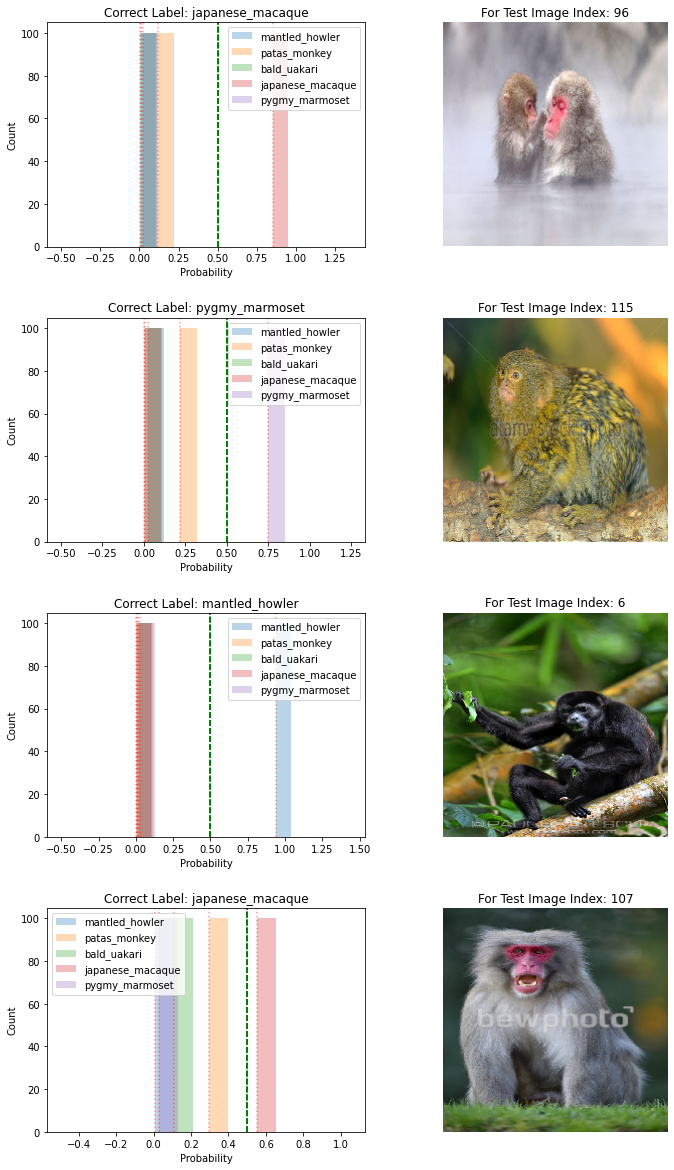

In [33]:
pred_non_bayesian = run_bayesian_approx(net, 100, test_images, enable_dropout=False)
visualize_probdist(4, pred_non_bayesian, test_images, test_labels, label_mapping)

### With dropout turned **ON** during inference time

There are 100 predictions for each test image. With dropout turned on, the network is not going to produce the same output each time the same image is passed through the network. This is what we want to capture. If there is a lot of model uncertainty, the distribution will have a huge standard deviation for each class.


In [34]:
pred_bayesian = run_bayesian_approx(net, 100, test_images, enable_dropout=True)

100%|██████████| 100/100 [00:12<00:00,  7.73it/s]


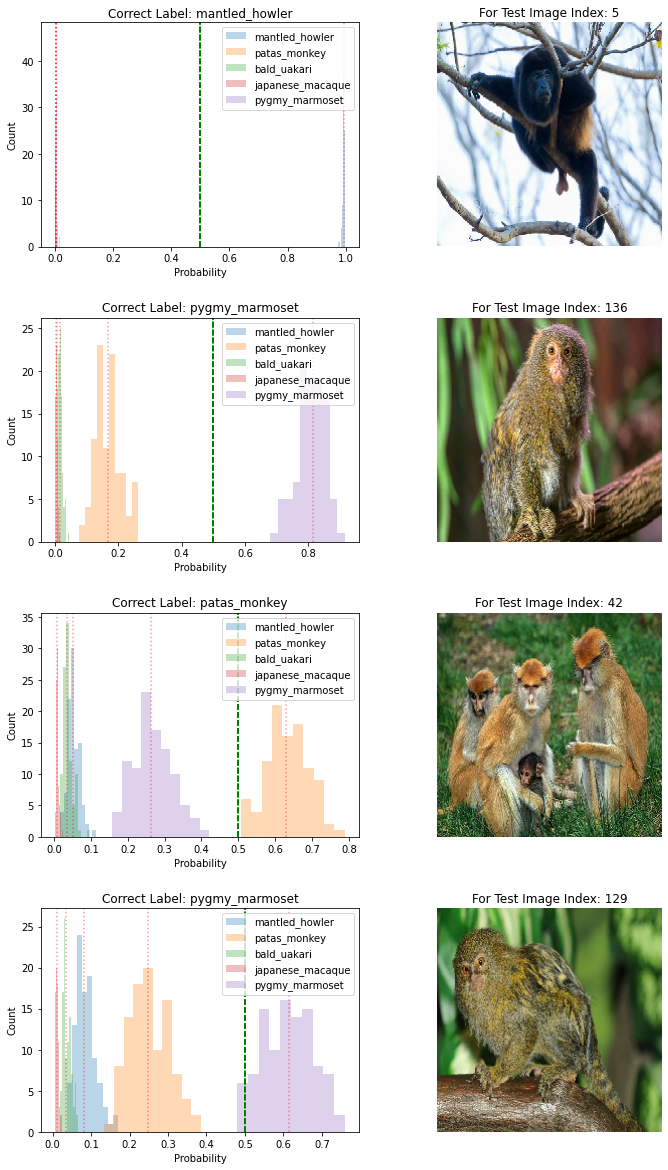

In [35]:
visualize_probdist(4, pred_bayesian, test_images, test_labels, label_mapping)

# Testing with Out of Distribution Data

### Testing with monkey classes which are not a part of the Training Dataset

In [0]:
# Selecting classes of monkey to train
new_class_filter = ['n5', 'n6', 'n7', 'n8', 'n9']
new_label_mapping = monkey_labels['Common Name'][5:].to_dict()
new_label_mapping = {k-5: v for k, v in new_label_mapping.items()} # Shift the index by 5 to make it indexable by label indicies

In [37]:
new_test_dataset = Dataset(path=test_dir, target_size=IMAGE_SHAPE[:2], dataset_type=DatasetType.TEST,
                           batch_size=BATCH_SIZE,
                           class_filter=new_class_filter, # Changed to new class filter
                           label_mapping=new_label_mapping) 

Found 135 images belonging to 5 classes.


In [38]:
new_test_images, new_test_labels = new_test_dataset.get_all_data()
new_pred_bayesian = run_bayesian_approx(net, 100, new_test_images, enable_dropout=True)

100%|██████████| 100/100 [00:12<00:00,  7.87it/s]


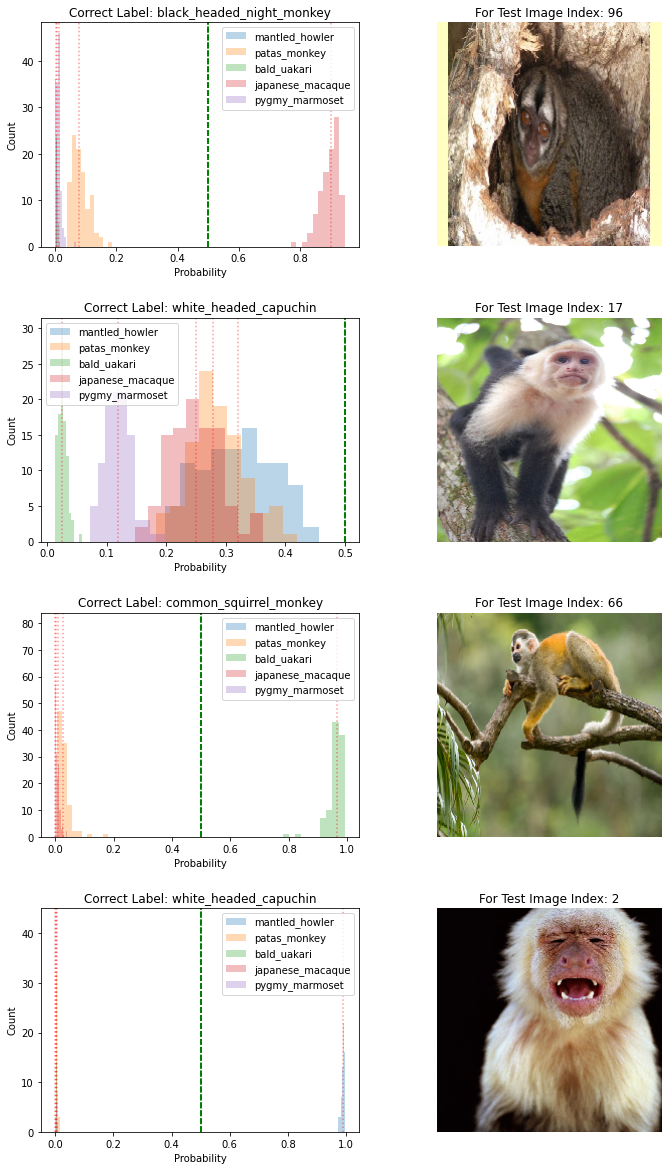

In [39]:
visualize_probdist(4, pred_bayesian, new_test_images, new_test_labels,
                   label_mapping, ood_mapping=new_label_mapping)

### Testing with completely different objects

Now, we want to see what do our probability distributions look like for completely different looking images. Here, I am using Animal_Object_20 dataset created from [Open Images](https://storage.googleapis.com/openimages/web/index.html) [Credit: [Myat Thu Hein](https://github.com/myatthuhein97/)]. I am going to use my monkey network to make multiple predictions with dropout turned on for Airplane, Car, Horse, and Chicken images. We will see how the probability distributions look like.

### Download Animals_Objects_20 dataset

In [0]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1rph5fGyJJHm6QMp9MmpQM2EIhgtkK34P
!mkdir animals_objects_dataset
!unzip animals_objects20.zip -d animals_objects_dataset

In [0]:
aniobj_test_dir = './animals_objects_dataset'
aniobj_class_filter = ['Airplane', 'Car']
aniobj_mapping = {i: x for i, x in enumerate(aniobj_class_filter)}

In [42]:
aniobj_test_dataset = Dataset(path=aniobj_test_dir, target_size=IMAGE_SHAPE[:2], dataset_type=DatasetType.TEST,
                              batch_size=BATCH_SIZE,
                              class_filter=aniobj_class_filter) 

Found 896 images belonging to 2 classes.


In [43]:
aniobj_test_images, aniobj_test_labels = aniobj_test_dataset.get_all_data()
aniobj_pred_bayesian = run_bayesian_approx(net, 100, aniobj_test_images, enable_dropout=True)

100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


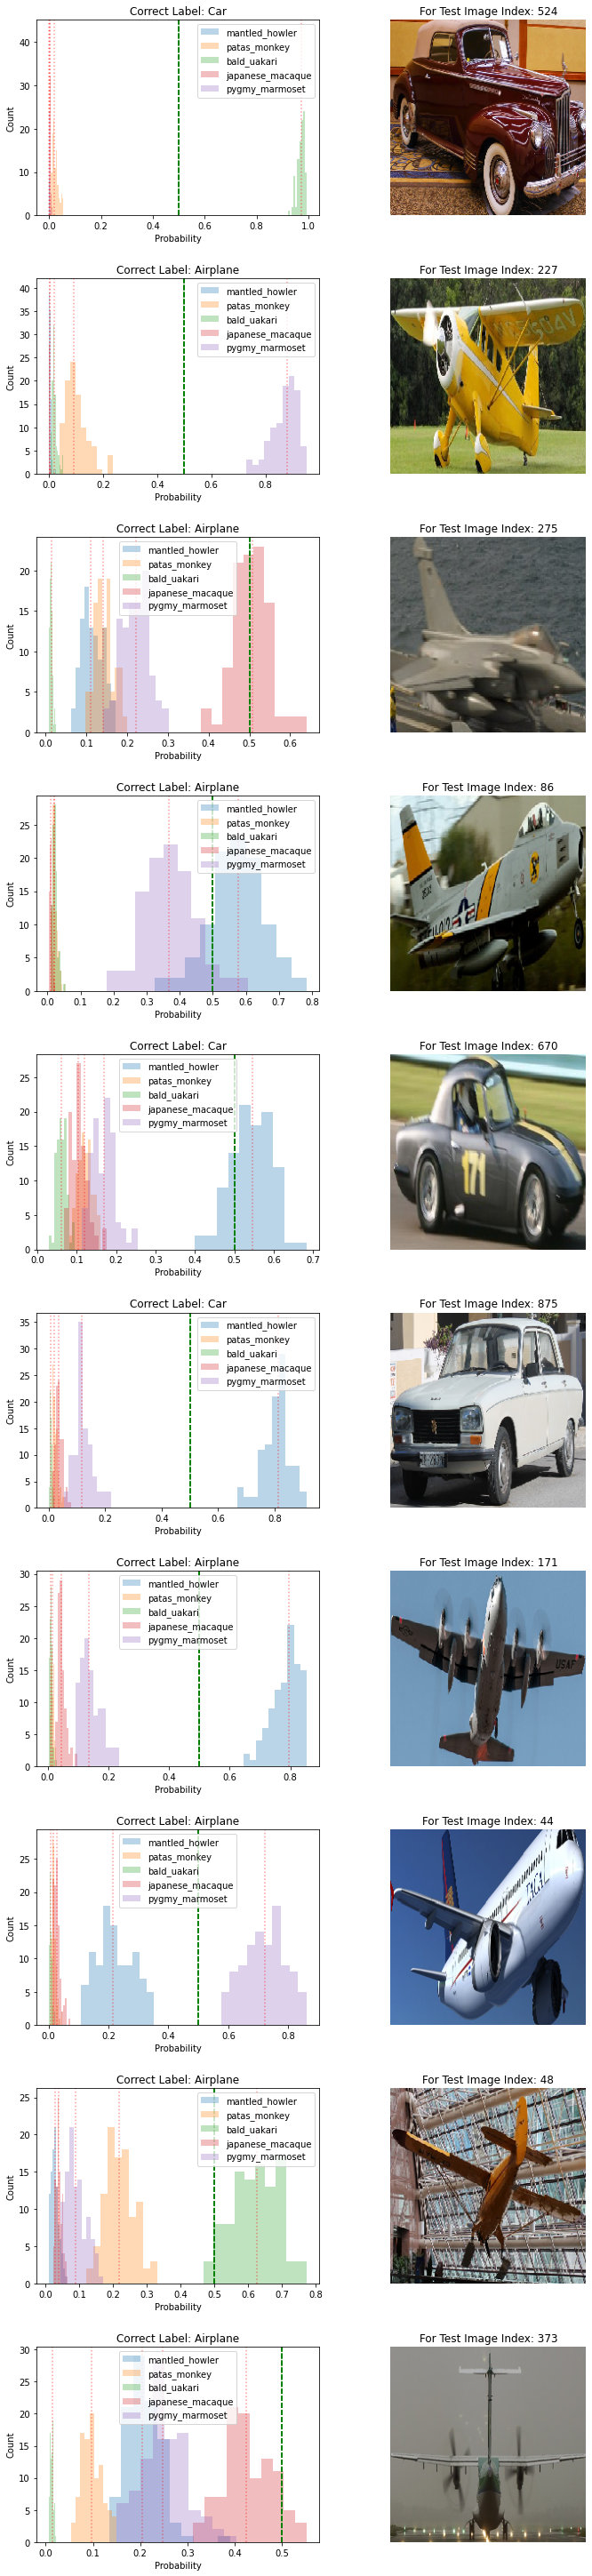

In [44]:
visualize_probdist(10, aniobj_pred_bayesian, aniobj_test_images, aniobj_test_labels,
                   label_mapping, ood_mapping=aniobj_mapping)

As we shall observe, **NOT ALL** probability distributions look that promising for out of distribution samples. Some of the distributions indicate confident predictions even though the network has never seen the types of animals/objects during training (Because the objects in the image or background look similar?)


But this does not mean that all hope is lost. We still can pick data points which have big spread in their probability distributions and send them off to annotators in active learning setting.

Futher analysis can be done by filtering images with output distributions which have any class distribution with median value greater than 0.5. We can analyze the samples which do not pass that criteria, and even send them to be labeled.